In [3]:
import pandas as pd
import os
import glob

folder_path = 'mouseTrackingData'

csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
dataframes = [pd.read_csv(file) for file in csv_files]
# filenames = [os.path.basename(file) for file in csv_files]


In [ ]:
cleaned_dataframes = []

for df in dataframes:
    df_cleaned = df[df['phase'] != 'waitingForTarget']              # Phase-Filter
    # df_cleaned = df_cleaned[df_cleaned['round'].isin([7, 8])]       # alle nach round 8 raus
    df_cleaned = df_cleaned.reset_index(drop=True)
    cleaned_dataframes.append(df_cleaned)


In [5]:
dataframes = cleaned_dataframes

In [6]:
dataframes[0]

,id,round,trial,version,timestamp,frame,relative_time,mouse_x,mouse_y,mouse_dx,mouse_dy,phase,event
0,1085,0,1,lld,14:12:59.707,3725,0.017,0.068,-0.100,0.0,0.0,activeTracking,targetAppeared
1,1085,0,1,lld,14:12:59.725,3726,0.035,0.068,-0.100,0.0,0.0,activeTracking,noEvent
2,1085,0,1,lld,14:12:59.740,3727,0.051,0.068,-0.100,0.0,0.0,activeTracking,noEvent
3,1085,0,1,lld,14:12:59.757,3728,0.067,0.068,-0.100,0.0,0.0,activeTracking,noEvent
4,1085,0,1,lld,14:12:59.772,3729,0.083,0.068,-0.100,0.0,0.0,activeTracking,noEvent
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71802,1085,16,60,lld,15:14:09.993,223573,0.951,2.680,0.051,0.0,0.0,onTarget,noEvent
71803,1085,16,60,lld,15:14:10.010,223574,0.967,2.681,0.051,0.0,0.0,onTarget,noEvent
71804,1085,16,60,lld,15:14:10.027,223575,0.983,2.681,0.051,0.0,0.0,onTarget,noEvent
71805,1085,16,60,lld,15:14:10.044,223576,1.000,2.681,0.051,0.0,0.0,onTarget,noEvent


In [7]:
# import matplotlib.pyplot as plt

# df = dataframes[0]
# # Stelle sicher, dass du die Spalten 'trial', 'mouse_x', 'mouse_y' hast
# trials = df['trial'].unique()

# plt.figure(figsize=(12, 6))

# for trial_id in trials:
#     trial_data = df[df['trial'] == trial_id]
#     plt.plot(trial_data['mouse_x'], trial_data['mouse_y'], label=f'Trial {trial_id}', alpha=0.6)

# plt.xlabel("mouse_x (Blick horizontal)")
# plt.ylabel("mouse_y (Blick vertikal)")
# plt.title("Blickpfade für alle Trials")
# plt.grid(True)
# plt.axis("equal")
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))  # Legende etwas außerhalb
# plt.tight_layout()
# plt.show()


### Nach round und trial filtern: es gibt 16 rounds mit jeweils 60 trials

In [8]:
all_grouped_df = []
for dataframe in dataframes:
    df_grouped = dataframe.groupby(['round', 'trial']).agg({
        'mouse_x': list,
        'mouse_y': list,
        'mouse_dx': list,
        'mouse_dy': list,
        'version': 'first'  # Falls du version behalten willst
    }).reset_index()

    all_grouped_df.append(df_grouped)

In [9]:
print(dataframes[0].head())
print(dataframes[0].groupby(['round', 'trial']).size())

     id  round  trial version     timestamp  frame  relative_time  mouse_x  \
0  1085      0      1     lld  14:12:59.707   3725          0.017    0.068   
1  1085      0      1     lld  14:12:59.725   3726          0.035    0.068   
2  1085      0      1     lld  14:12:59.740   3727          0.051    0.068   
3  1085      0      1     lld  14:12:59.757   3728          0.067    0.068   
4  1085      0      1     lld  14:12:59.772   3729          0.083    0.068   

   mouse_y  mouse_dx  mouse_dy           phase           event  
0     -0.1       0.0       0.0  activeTracking  targetAppeared  
1     -0.1       0.0       0.0  activeTracking         noEvent  
2     -0.1       0.0       0.0  activeTracking         noEvent  
3     -0.1       0.0       0.0  activeTracking         noEvent  
4     -0.1       0.0       0.0  activeTracking         noEvent  
round  trial
0      1         97
       2        106
       3        107
       4        100
       5         86
               ... 
16     5

In [10]:
print(len(all_grouped_df[0]))  # → 60 trials
print(len(all_grouped_df[0]['mouse_x'][2]))  # → 121 Werte pro trial

970
107


### Daten auf 100 timesteps interpolieren

In [11]:
import numpy as np
# def interpolate_positions(row):
#     x_positions = np.array(row["mouse_x"])
#     y_positions = np.array(row["mouse_y"])
    
#     original_length = len(x_positions)
#     original_time = np.linspace(0, 1, original_length)  # z.B. von 0 bis 1 für alle Punkte
#     new_time = np.linspace(0, 1, 100)                  # 100 neue Zeitpunkte
    
#     x_interp = np.interp(new_time, original_time, x_positions)
#     y_interp = np.interp(new_time, original_time, y_positions)
    
#     row["mouse_x"] = x_interp
#     row["mouse_y"] = y_interp
    
#     return row


### Koordinaten auf -1 bis 1 normalisieren

In [12]:
# def normalize_to_minus1_plus1(arr):
#     arr = np.array(arr)
#     min_val = arr.min()
#     max_val = arr.max()
#     if min_val == max_val:
#         return np.zeros_like(arr)
#     normalized_0_1 = (arr - min_val) / (max_val - min_val)
#     normalized_m1_1 = normalized_0_1 * 2 - 1
#     return normalized_m1_1


In [13]:
def normalize_positions(row):
    # Normalisieren (Startpunkt auf 0,0 setzen)
    x_positions = np.array(row["mouse_x"])
    y_positions = np.array(row["mouse_y"])
    
    x_start, y_start = x_positions[0], y_positions[0]
    x_norm = x_positions - x_start
    y_norm = y_positions - y_start

    row["mouse_x"] = x_norm
    row["mouse_y"] = y_norm

    return row


In [14]:
def normalize_and_interpolate(row):
    # Normalisieren (Startpunkt auf 0,0 setzen)
    x_positions = np.array(row["mouse_x"])
    y_positions = np.array(row["mouse_y"])
    x_start, y_start = x_positions[0], y_positions[0]
    
    x_norm = x_positions - x_start
    y_norm = y_positions - y_start

    # Interpolieren auf 100 Punkte
    original_length = len(x_norm)
    original_time = np.linspace(0, 1, original_length)
    new_time = np.linspace(0, 1, 100)
    
    x_interp = np.interp(new_time, original_time, x_norm)
    y_interp = np.interp(new_time, original_time, y_norm)
    
    row["mouse_x"] = x_interp
    row["mouse_y"] = y_interp
    
    return row

In [15]:
processed_dataframes = []
for df in all_grouped_df:
    df_processed = df.apply(normalize_positions, axis=1)
    processed_dataframes.append(df_processed)

In [16]:
all_grouped_df = processed_dataframes

In [17]:
# for i, grouped_df in enumerate(all_grouped_df):
#     print(f"DataFrame {i}:")
#     for idx, row in grouped_df.iterrows():
#         max_x = max(row["mouse_x"])
#         min_x = min(row["mouse_x"])
#         print(f"  Zeile {idx}: max mouse_x = {max_x}, min mouse_x = {min_x}")

In [18]:
all_grouped_df[0].head()

,round,trial,mouse_x,mouse_y,mouse_dx,mouse_dy,version
0,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld
1,0,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld
2,0,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld
3,0,4,"[0.0, 0.0, 0.0, 0.0, 0.0, -0.01100000000000001...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.02...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.1, 0.0, 0.0, -0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.2,...",lld
4,0,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld


In [19]:
df_lld = []
df_rld = []

for df in all_grouped_df:
    version = df.iloc[0]['version']  # Version der ersten Zeile
    if version == 'lld':
        df_lld.append(df)
    elif version == 'rld':
        df_rld.append(df)


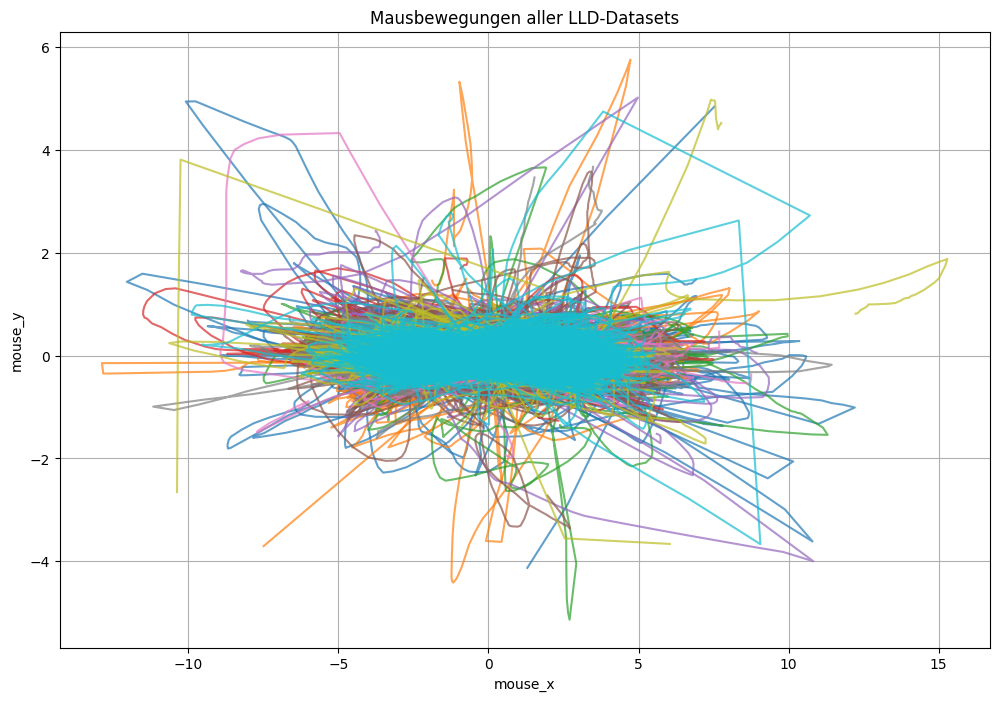

In [20]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import numpy as np

plt.figure(figsize=(12, 8))

num_dfs = len(df_lld)
colors = cm.tab10(np.linspace(0, 1, num_dfs))
for i, df in enumerate(df_lld):
    color = colors[i] 
    for idx, row in df.iterrows():
        x = row['mouse_x']
        y = row['mouse_y']
        plt.plot(x, y, color=color, alpha=0.7)

plt.xlabel('mouse_x')
plt.ylabel('mouse_y')
plt.title('Mausbewegungen aller LLD-Datasets')
plt.grid(True)
plt.show()


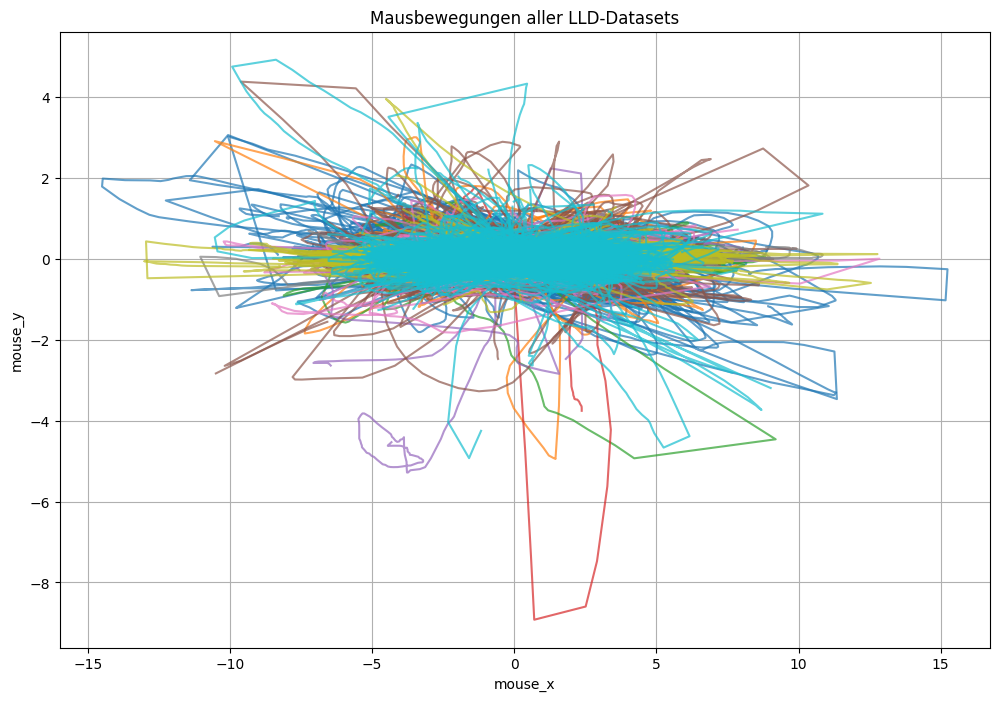

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

plt.figure(figsize=(12, 8))

num_dfs = len(df_rld)
colors = cm.tab10(np.linspace(0, 1, num_dfs))
for i, df in enumerate(df_rld):
    color = colors[i] 
    for idx, row in df.iterrows():
        x = row['mouse_x']
        y = row['mouse_y']
        plt.plot(x, y, color=color, alpha=0.7)

plt.xlabel('mouse_x')
plt.ylabel('mouse_y')
plt.title('Mausbewegungen aller LLD-Datasets')
plt.grid(True)
plt.show()

## Hinzufügen von targetPos um herauszufinden, wie sich die mauspositionen je nach seite unterscheiden

In [22]:
def get_target_pos(row):
    last_x = row['mouse_x'][-1]
    return 'r' if last_x > 0 else 'l'

df['targetPos'] = df.apply(get_target_pos, axis=1)

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [ ]:
for i, df in enumerate(df_lld):
    target_pos_series = df.apply(get_target_pos, axis=1)
    df_lld[i] = df.copy() 
    df_lld[i]['targetPos'] = target_pos_series

In [ ]:
for i, df in enumerate(df_rld):
    target_pos_series = df.apply(get_target_pos, axis=1)
    df_rld[i] = df.copy()  # sicherstellen, dass es ein DataFrame ist
    df_rld[i]['targetPos'] = target_pos_series

### Jetzt werden die zwei conditions noch nach targetPos aufgesplittet

In [ ]:
df_lld_left_target = []
df_lld_right_target = []

for df in df_lld:
    df_left = df[df['targetPos'] == 'l'].reset_index(drop=True)
    df_right = df[df['targetPos'] == 'r'].reset_index(drop=True)
    df_lld_left_target.append(df_left)
    df_lld_right_target.append(df_right)


In [ ]:
df_lld_left_target[0]

,round,trial,mouse_x,mouse_y,mouse_dx,mouse_dy,version,targetPos
0,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,l
1,0,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,l
2,0,4,"[0.0, 0.0, 0.0, 0.0, 0.0, -0.01100000000000001...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.02...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.1, 0.0, 0.0, -0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.2,...",lld,l
3,0,7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0052121...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00477777...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1, -0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, -0.1,...",lld,l
4,0,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,l
...,...,...,...,...,...,...,...,...
471,16,49,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 1.4, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1, 0.2,...",lld,l
472,16,50,"[0.0, -0.10175757575757585, -0.174363636363636...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.2, -0.6, -0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,l
473,16,53,"[0.0, -0.04321212121212131, -0.086424242424242...","[0.0, -0.0013939393939393953, -0.0027878787878...","[-0.9, -0.2, -0.5, -0.2, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,l
474,16,54,"[0.0, -0.03354545454545462, -0.067090909090909...","[0.0, -0.0033131313131313047, -0.0066262626262...","[-0.6, -0.2, -0.3, 0.0, -0.1, 0.0, -0.1, -0.2,...","[-0.1, 0.0, -0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",lld,l


In [ ]:
df_rld_left_target = []
df_rld_right_target = []

for df in df_rld:
    df_left = df[df['targetPos'] == 'l'].reset_index(drop=True)
    df_right = df[df['targetPos'] == 'r'].reset_index(drop=True)
    df_rld_left_target.append(df_left)
    df_rld_right_target.append(df_right)


In [ ]:
df_rld_left_target[0]

,round,trial,mouse_x,mouse_y,mouse_dx,mouse_dy,version,targetPos
0,0,1,"[0.0, -0.024565656565656555, -0.04180808080808...","[0.0, 0.020040404040404025, 0.0342222222222221...","[-0.5, -0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",rld,l
1,0,2,"[0.0, 0.009696969696969697, 0.0164646464646464...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",rld,l
2,0,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1, 0.0,...",rld,l
3,0,7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",rld,l
4,0,10,"[0.0, -0.007575757575757576, -0.01516161616161...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.1, -0.1, -0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",rld,l
...,...,...,...,...,...,...,...,...
470,16,55,"[0.0, -0.00650505050505048, -0.013010101010100...","[0.0, 0.0, 0.0, 0.0, 0.0015757575757575789, 0....","[-0.3, -0.1, -0.1, -0.1, -0.4, -0.4, -0.4, 0.0...","[0.0, 0.0, 0.1, 0.0, 0.1, 0.0, 0.1, 0.0, 0.0, ...",rld,l
471,16,56,"[0.0, -0.08290909090909093, -0.165818181818181...","[0.0, -0.005818181818181817, -0.01163636363636...","[-1.0, -2.1, -0.5, -0.1, 0.0, 0.0, 0.0, 0.0, 0...","[-0.1, -0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",rld,l
472,16,58,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, -0.1, -0.3, -0.1, -0.5, -...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.1, 0.0, 0.0, 0.0,...",rld,l
473,16,59,"[0.0, -0.008131313131313114, -0.01626262626262...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, -0.1, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",rld,l


In [ ]:
df_lld_left_target[1]

,round,trial,mouse_x,mouse_y,mouse_dx,mouse_dy,version,targetPos
0,0,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01133333...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.001666666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1,...",lld,l
1,0,3,"[0.0, -0.0038888888888888927, -0.0072222222222...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 2.3, 0.4, 0.1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.0, 0.0, ...",lld,l
2,0,6,"[0.0, -0.004888888888888894, -0.00977777777777...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, -0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, ...",lld,l
3,0,7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,l
4,0,9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,l
...,...,...,...,...,...,...,...,...
482,16,54,"[0.0, 0.0, 0.007424242424242427, 0.08463636363...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001515151515...","[0.0, 0.0, 1.3, 0.3, 0.0, 0.5, 0.8, 0.5, 0.5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,l
483,16,56,"[0.0, 0.010828282828282838, 0.0181212121212121...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0606060606060...","[0.0, 0.0, 0.0, 0.0, 2.1, 0.6, 0.1, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,l
484,16,57,"[0.0, 0.0039595959595959095, 0.004979797979797...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.00949494949494950...","[0.1, 0.0, 0.0, 0.1, 1.1, 3.9, 2.1, 0.6, 0.4, ...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.1, 0.0, 0.0, 0.0,...",lld,l
485,16,59,"[0.0, 0.004606060606060611, 0.0136060606060606...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0154545454545...","[0.0, 0.0, 0.3, 0.4, 1.3, 0.5, 0.0, 0.0, 0.4, ...","[0.0, 0.0, 0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 0.0, ...",lld,l


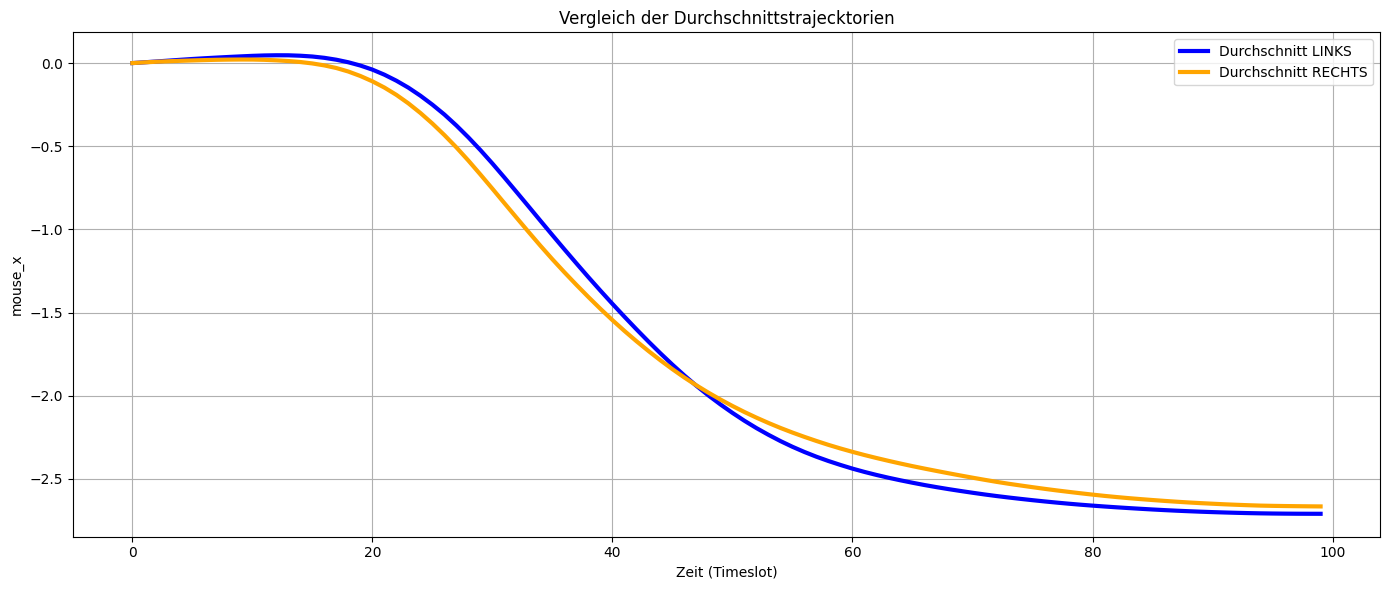

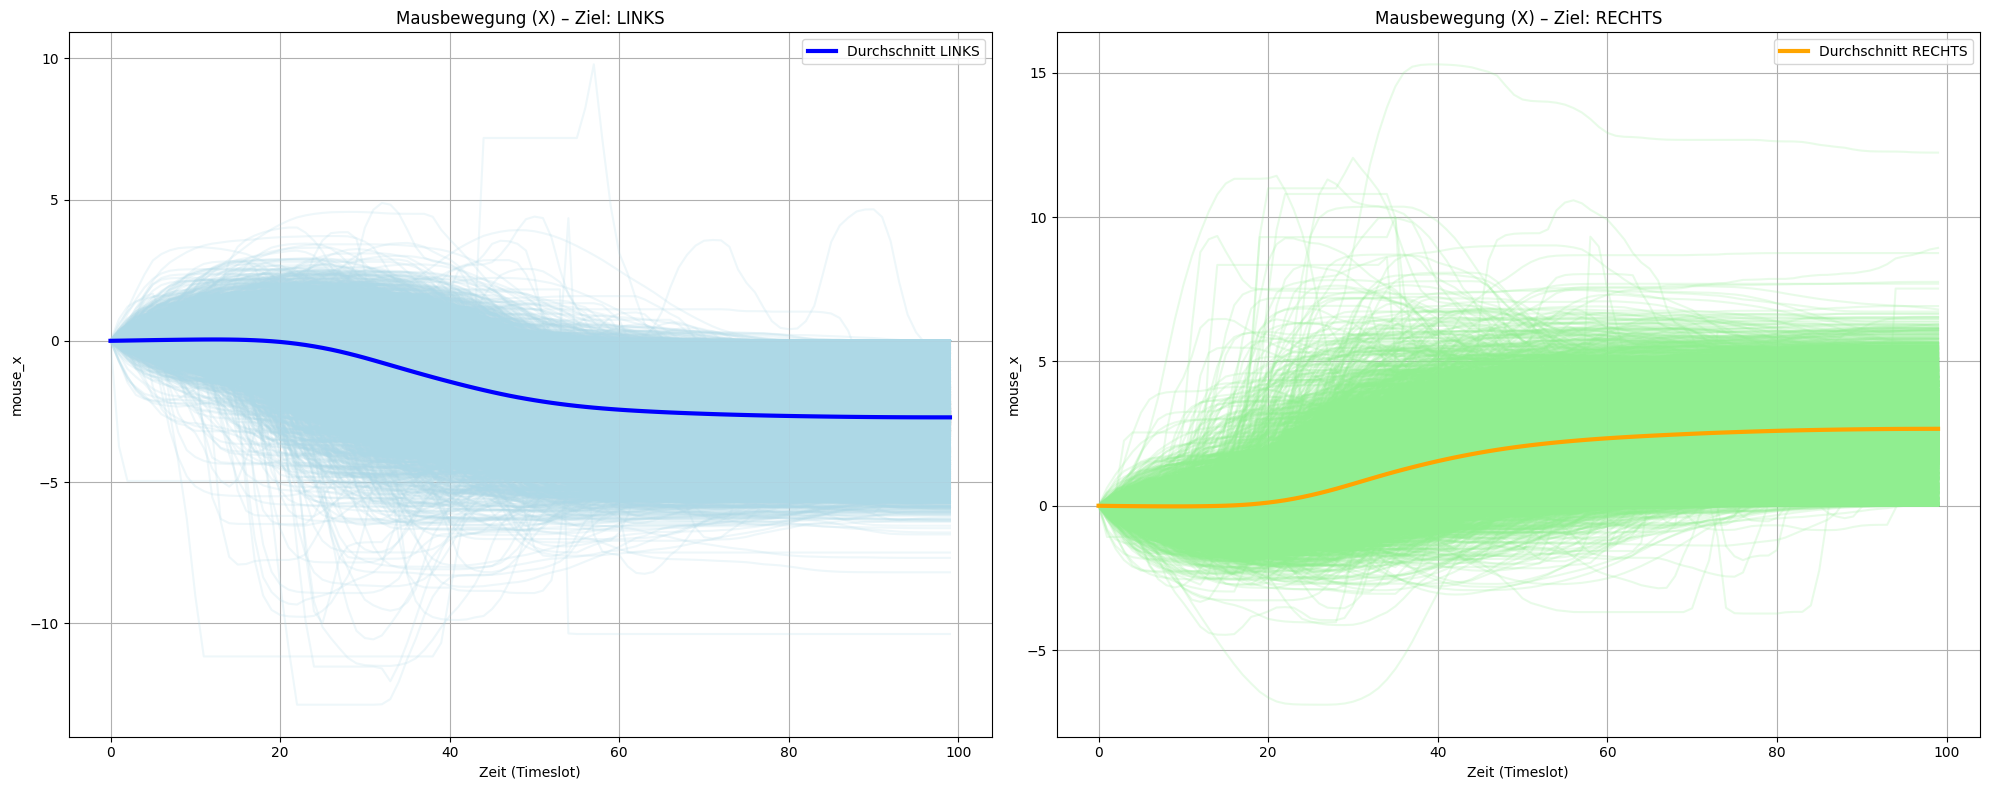

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_average_trajectory(df_list):
    """Berechnet den Durchschnitt aller Trajektorien"""
    all_trajectories = []
    
    for df in df_list:
        for idx, row in df.iterrows():
            if hasattr(row['mouse_x'], '__len__') and len(row['mouse_x']) > 0:
                all_trajectories.append(row['mouse_x'])
    
    if not all_trajectories:
        return np.array([])
    
    # Finde die maximale Länge
    max_length = max(len(traj) for traj in all_trajectories)
    
    # Interpoliere alle Trajektorien auf die gleiche Länge
    interpolated_trajectories = []
    for traj in all_trajectories:
        if len(traj) > 1:
            # Interpoliere auf max_length
            old_indices = np.linspace(0, len(traj)-1, len(traj))
            new_indices = np.linspace(0, len(traj)-1, max_length)
            interpolated = np.interp(new_indices, old_indices, traj)
            interpolated_trajectories.append(interpolated)
    
    if interpolated_trajectories:
        return np.mean(interpolated_trajectories, axis=0)
    else:
        return np.array([])

# Berechne Durchschnittstrajecktorien
avg_left = calculate_average_trajectory(df_lld_left_target)
avg_right = calculate_average_trajectory(df_lld_right_target)

# --- Vergleichsplot: Beide Durchschnitte zusammen ---
plt.figure(figsize=(14, 6))

if len(avg_left) > 0:
    plt.plot(range(len(avg_left)), avg_left, color='blue', linewidth=3, label='Durchschnitt LINKS')
if len(avg_right) > 0:
    plt.plot(range(len(avg_right)), -avg_right, color='orange', linewidth=3, label='Durchschnitt RECHTS')

plt.title('Vergleich der Durchschnittstrajecktorien')
plt.xlabel('Zeit (Timeslot)')
plt.ylabel('mouse_x')
# plt.xlim(0, 500)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Alle zusammen: Einzelne Trajektorien + Durchschnitte ---
plt.figure(figsize=(20, 8))

# Links
plt.subplot(1, 2, 1)
for df_idx, df in enumerate(df_lld_left_target):
    for idx, row in df.iterrows():
        if hasattr(row['mouse_x'], '__len__') and len(row['mouse_x']) > 0:
            plt.plot(range(len(row['mouse_x'])), row['mouse_x'], alpha=0.2, color='lightblue')

if len(avg_left) > 0:
    plt.plot(range(len(avg_left)), avg_left, color='blue', linewidth=3, label='Durchschnitt LINKS')
    plt.legend()

plt.title('Mausbewegung (X) – Ziel: LINKS')
plt.xlabel('Zeit (Timeslot)')
plt.ylabel('mouse_x')
# plt.xlim(0, 500)
plt.grid(True)

# Rechts
plt.subplot(1, 2, 2)
for df_idx, df in enumerate(df_lld_right_target):
    for idx, row in df.iterrows():
        if hasattr(row['mouse_x'], '__len__') and len(row['mouse_x']) > 0:
            plt.plot(range(len(row['mouse_x'])), row['mouse_x'], alpha=0.2, color='lightgreen')

if len(avg_right) > 0:
    plt.plot(range(len(avg_right)), avg_right, color='orange', linewidth=3, label='Durchschnitt RECHTS')
    plt.legend()

plt.title('Mausbewegung (X) – Ziel: RECHTS')
plt.xlabel('Zeit (Timeslot)')
plt.ylabel('mouse_x')
# plt.xlim(0, 500)
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def normalize_to_target_progress(traj, target_x):
    """
    Normalisiert eine Mausbewegungstrajektorie (X) als prozentualen Fortschritt zum Ziel.
    Start = 0 %, Ziel = 100 %
    """
    start_x = traj[0]
    end_x = target_x
    
    distance = end_x - start_x
    if distance == 0:
        return np.zeros_like(traj)
    
    progress = [(x - start_x) / distance * 100 for x in traj]
    return progress


In [ ]:
def calculate_average_progress(df_list, target_x):
    """Berechnet den Mittelwert aller normierten Trajektorien (100 Timesteps)"""
    all_progress = []

    for df in df_list:
        for _, row in df.iterrows():
            traj = row['mouse_x']
            if len(traj) == 100:  # Da du bereits interpoliert hast
                progress = normalize_to_target_progress(traj, target_x)
                all_progress.append(progress)

    if all_progress:
        return np.mean(all_progress, axis=0)
    else:
        return np.array([])


C:\Users\m_uel\AppData\Local\Temp\ipykernel_27172\2407936608.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\m_uel\Desktop\Masterarbeit\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


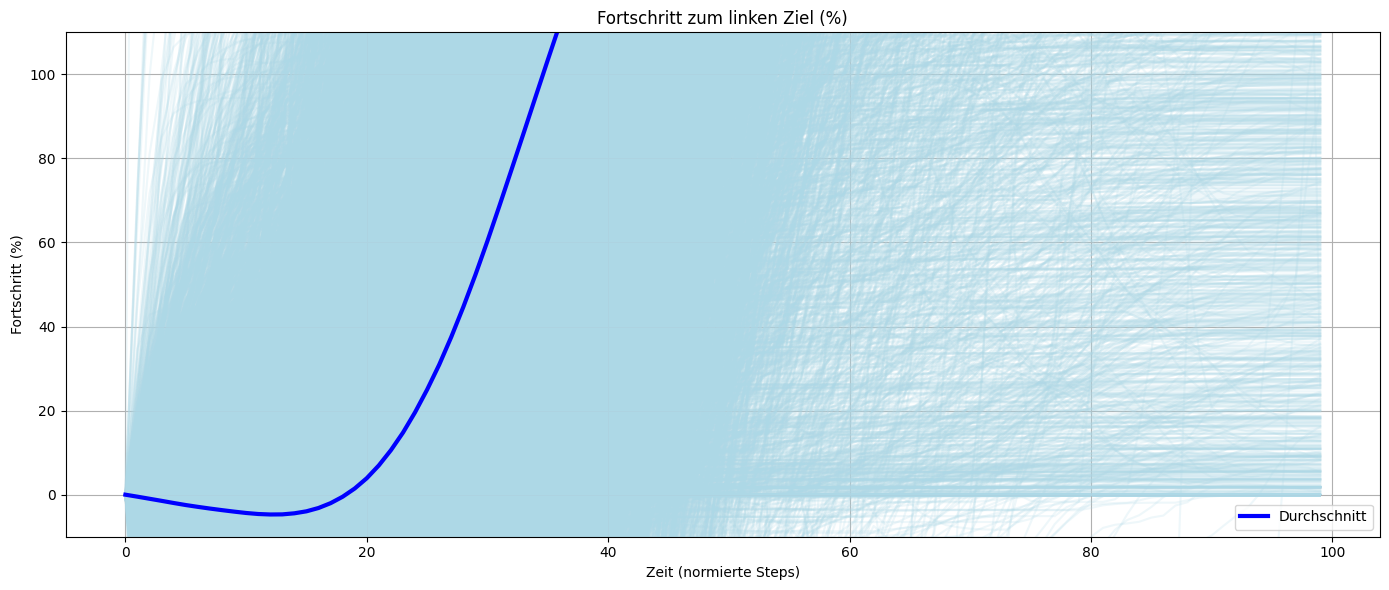

In [ ]:
plt.figure(figsize=(14, 6))

# Einzelne Trajektorien
for df in df_lld_left_target:
    for _, row in df.iterrows():
        traj = row['mouse_x']
        if len(traj) == 100:
            progress = normalize_to_target_progress(traj, target_x=-1.0)
            plt.plot(range(100), progress, alpha=0.2, color='lightblue')

# Durchschnitt
avg_progress = calculate_average_progress(df_lld_left_target, target_x=-1.0)
if len(avg_progress) > 0:
    plt.plot(range(100), avg_progress, color='blue', linewidth=3, label='Durchschnitt')

plt.title("Fortschritt zum linken Ziel (%)")
plt.xlabel("Zeit (normierte Steps)")
plt.ylabel("Fortschritt (%)")
plt.ylim(-10, 110)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(14, 6))

# Einzelne Trajektorien
for df in df_lld_right_target:
    for _, row in df.iterrows():
        traj = row['mouse_x']
        if len(traj) == 100:
            progress = normalize_to_target_progress(traj, target_x=-1.0)
            progress = np.array(progress) 
            plt.plot(range(100), -progress, alpha=0.2, color='lightblue')

# Durchschnitt
avg_progress = calculate_average_progress(df_lld_right_target, target_x=-1.0)
if len(avg_progress) > 0:
    plt.plot(range(100), -avg_progress, color='blue', linewidth=3, label='Durchschnitt')

plt.title("Fortschritt zum linken Ziel (%)")
plt.xlabel("Zeit (normierte Steps)")
plt.ylabel("Fortschritt (%)")
plt.ylim(-10, 110)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\m_uel\AppData\Local\Temp\ipykernel_27172\2103829301.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import numpy as np

# plt.figure(figsize=(12, 8))

# num_dfs = len(df_rld_left_target)
# colors = cm.tab10(np.linspace(0, 1, num_dfs))

# for i, df in enumerate(df_rld_left_target):
#     color = colors[i] 
#     for idx, row in df.iterrows():
#         x = row['mouse_x']
#         y = row['mouse_y']
        
#         # Nur Start- und Endpunkt einzeichnen
#         plt.scatter(x[0], y[0], color='green', s=30, label='Start' if i == 0 and idx == 0 else "")
#         plt.scatter(x[-1], y[-1], color='red', s=30, label='Ende' if i == 0 and idx == 0 else "")

# plt.xlabel('mouse_x')
# plt.ylabel('mouse_y')
# plt.title('Start- und Endpunkte aller RLD-Datasets auf das linke Target')
# plt.grid(True)
# plt.legend()
# plt.show()


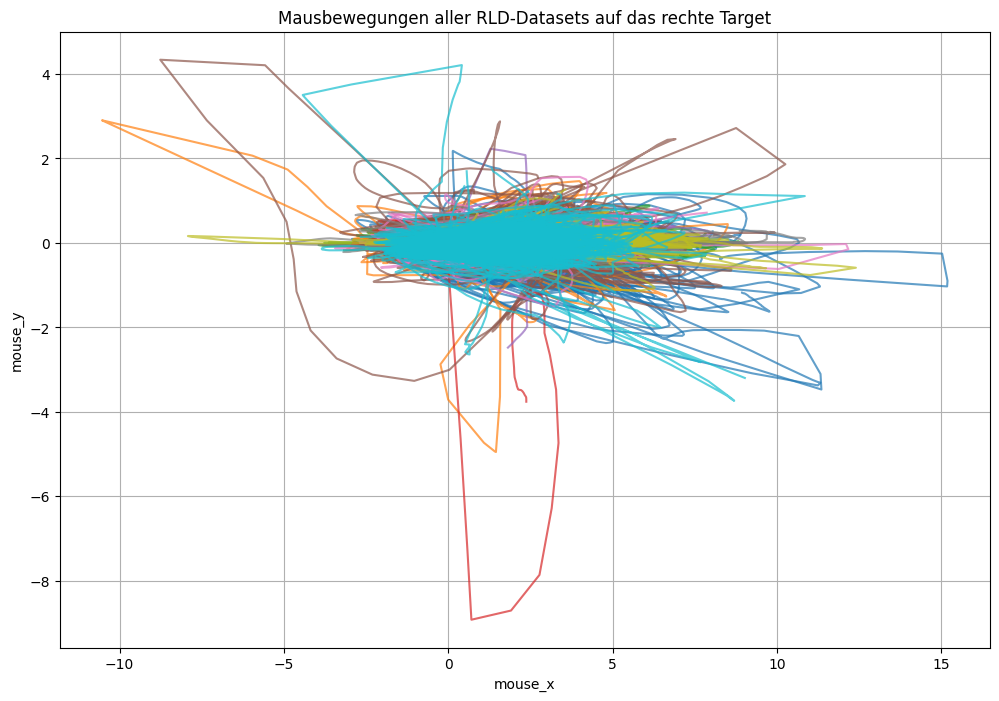

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

plt.figure(figsize=(12, 8))

num_dfs = len(df_rld_right_target)
colors = cm.tab10(np.linspace(0, 1, num_dfs))
for i, df in enumerate(df_rld_right_target):
    color = colors[i] 
    for idx, row in df.iterrows():
        x = row['mouse_x']
        y = row['mouse_y']
        plt.plot(x, y, color=color, alpha=0.7)

plt.xlabel('mouse_x')
plt.ylabel('mouse_y')
plt.title('Mausbewegungen aller RLD-Datasets auf das rechte Target')
plt.grid(True)
plt.show()

In [ ]:
def create_trajectory_heatmap(df_data, title, bins=50, sigma=2):
    """Erstellt eine Heatmap der Trajectory-Dichte"""
    from scipy.ndimage import gaussian_filter
    
    if len(df_data) == 0:
        print(f"Keine Daten für Heatmap: {title}")
        return
    
    # Alle Punkte aus allen Trajectories sammeln
    all_x = []
    all_y = []
    
    for idx, row in df_data.iterrows():
        x_traj = row['mouse_x']
        y_traj = row['mouse_y']
        all_x.extend(x_traj)
        all_y.extend(y_traj)
    
    all_x = np.array(all_x)
    all_y = np.array(all_y)
    
    # Heatmap erstellen
    plt.figure(figsize=(10, 8))
    
    # 2D Histogram
    counts, xedges, yedges = np.histogram2d(all_x, all_y, bins=bins)
    
    # Gaussian Filter für weichere Darstellung
    counts_smooth = gaussian_filter(counts, sigma=sigma)
    
    # Heatmap plotten
    im = plt.imshow(counts_smooth.T, origin='lower', 
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    cmap='hot', aspect='auto', interpolation='bilinear')
    
    plt.colorbar(im, label='Dichte')
    plt.xlabel('X Position (normalisiert)')
    plt.ylabel('Y Position (normalisiert)')
    plt.title(f'Bewegungsdichte Heatmap: {title}')
    
    # Quadranten-Linien
    plt.axhline(y=0, color='white', linestyle='--', alpha=0.7)
    plt.axvline(x=0, color='white', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

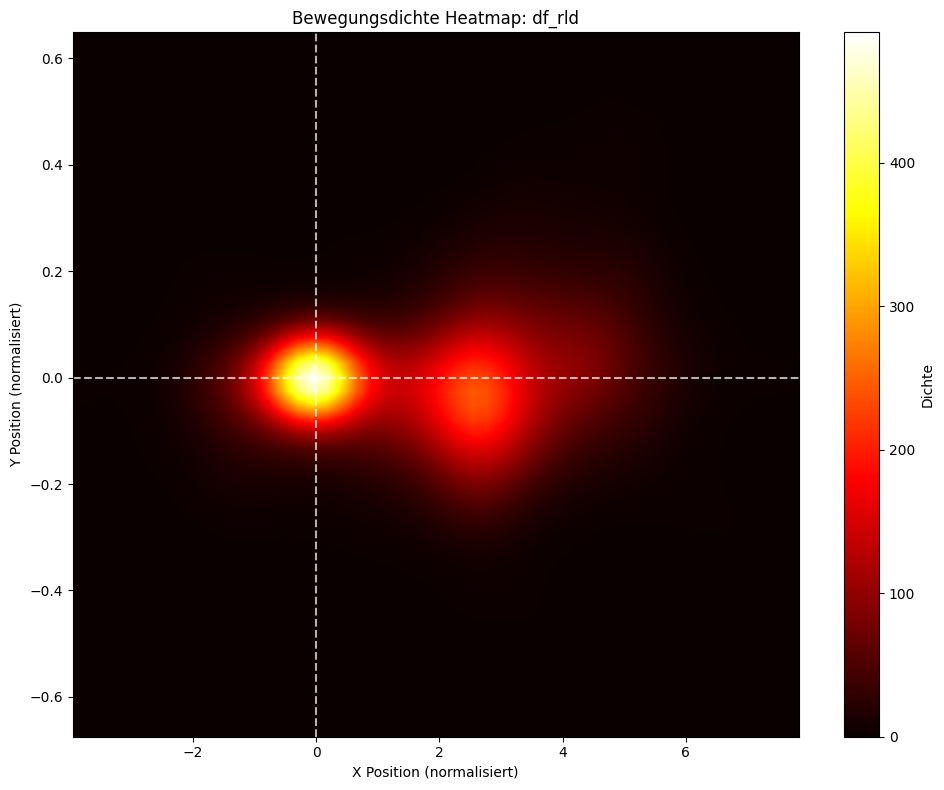

In [ ]:
create_trajectory_heatmap(df_rld_right_target[6], "df_rld")

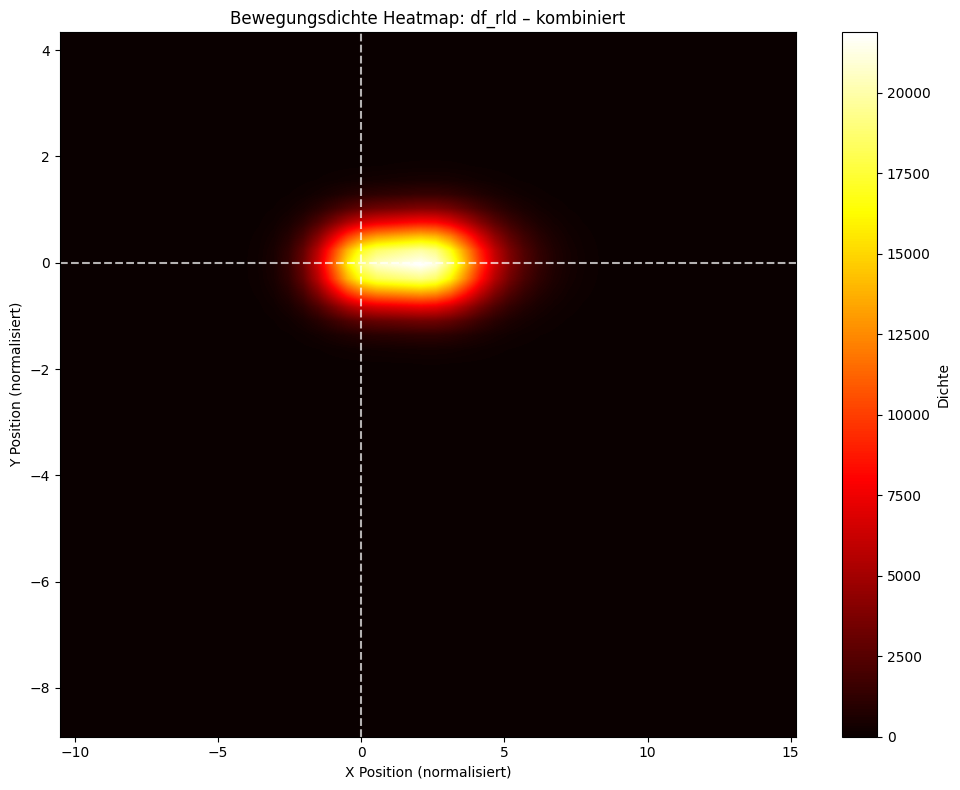

In [ ]:
# Kombiniere alle DataFrames in der Liste zu einem großen DataFrame
combined_df = pd.concat(df_rld_right_target, ignore_index=True)

# Heatmap aus allen zusammen
create_trajectory_heatmap(combined_df, "df_rld – kombiniert")